In [1]:
from datetime import datetime, timedelta
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import numpy as np
import colorsys
import colorcet as cc
import pandas as pd
import pytz
import re
import seaborn as sns

In [2]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [3]:
# Open the georeferenced RGB image using rasterio
image_path = 'lunt_2019_structure_modified.tif'
src = rasterio.open(image_path)

# Read the image bands (assuming they are stored in channels R, G, B)
red = src.read(1)
green = src.read(2)
blue = src.read(3)

# Stack the bands to create an RGB image
rgb_image = rasterio.plot.reshape_as_image([red, green, blue])

In [4]:
# Read the text file
with open('bmkg_twitter_info.txt', 'r') as file:
    lines = file.readlines()

# Initialize empty lists to store data
magnitudes = []
dates = []
times = []
longitudes = []
latitudes = []
depths = []
data_sources = []

# Define regex patterns
mag_pattern = r"Mag:(\d+\.\d+)"
date_pattern = r"(\d{1,2}-\w{3}-\d{4})"
time_pattern = r"\d{2}:\d{2}:\d{2}"
loc_pattern = r"Lok:(\d+\.\d+)LS, (\d+\.\d+)BT"
depth_pattern = r"Kedlmn:(\d+) Km"

# Loop through each line and extract information
for line in lines:
    # Extract magnitude
    mag_match = re.search(mag_pattern, line)
    magnitudes.append(float(mag_match.group(1)))

    # Extract date
    date_match = re.search(date_pattern, line)
    dates.append(date_match.group(1))

    # Extract time
    time_match = re.search(time_pattern, line)
    time_str = time_match.group()
    # Define time object as UTC+7
    time_obj = datetime.strptime(time_str, "%H:%M:%S")
    time_obj = pytz.timezone('Asia/Jakarta').localize(time_obj)
    time_obj = time_obj.astimezone(pytz.utc)
    times.append(time_obj.strftime("%H:%M:%S"))

    # Extract latitude and longitude
    loc_match = re.search(loc_pattern, line)
    latitudes.append(-1*float(loc_match.group(1)))
    longitudes.append(float(loc_match.group(2)))

    # Extract depth
    depth_match = re.search(depth_pattern, line)
    depths.append(float(depth_match.group(1)))

    # Extract data source
    data_sources.append("BMKG")

# Create DataFrame
df = pd.DataFrame({
    'Magnitude': magnitudes,
    'Date': dates,
    'Time': times,
    'Longitude': longitudes,
    'Latitude': latitudes,
    'Depth': depths,
    'DataSource': data_sources
})

# Print the DataFrame
print(df)

    Magnitude         Date      Time  Longitude  Latitude  Depth DataSource
0         3.7  11-Mar-2023  07:31:13     112.09     -6.16   10.0       BMKG
1         6.0  22-Mar-2024  04:15:45     112.32     -5.74   10.0       BMKG
2         6.1  22-Mar-2024  04:15:45     112.32     -5.74   10.0       BMKG
3         4.5  22-Mar-2024  04:28:13     112.34     -5.64   10.0       BMKG
4         3.3  22-Mar-2024  04:49:24     112.38     -5.73   10.0       BMKG
..        ...          ...       ...        ...       ...    ...        ...
79        4.0  28-Mar-2024  12:02:31     112.38     -5.78   10.0       BMKG
80        4.0  29-Mar-2024  18:22:36     112.43     -5.69   10.0       BMKG
81        4.6  29-Mar-2024  21:16:02     112.53     -5.73   10.0       BMKG
82        3.2  29-Mar-2024  21:35:38     112.50     -5.68   10.0       BMKG
83        3.5  29-Mar-2024  23:40:09     112.11     -6.19   10.0       BMKG

[84 rows x 7 columns]


In [5]:
# Convert Date column to datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract day and hour
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour

# Calculate brightness based on the hour of the day
# Normalize hour to range [0.3, 1]
min_hour = df['Hour'].min()
max_hour = df['Hour'].max()
df['brightness_plot'] = 0.7 * ((df['Hour'] - min_hour) / (max_hour - min_hour)) + 0.3  # Normalize hour to range [0, 1]

# Define color palette for days
rainbow_colors = cc.CET_R3
n_days = df['Day'].nunique()
day_indices = [int(i * (len(rainbow_colors) - 1) / (n_days - 1)) for i in range(n_days)]
palette = np.array([rainbow_colors[idx] for idx in day_indices])
palette

array(['#085cf8', '#2f917d', '#64ae1d', '#afc016', '#f2cc1c', '#fea169',
       '#fc6b9a', '#f13677', '#d60400'], dtype='<U7')

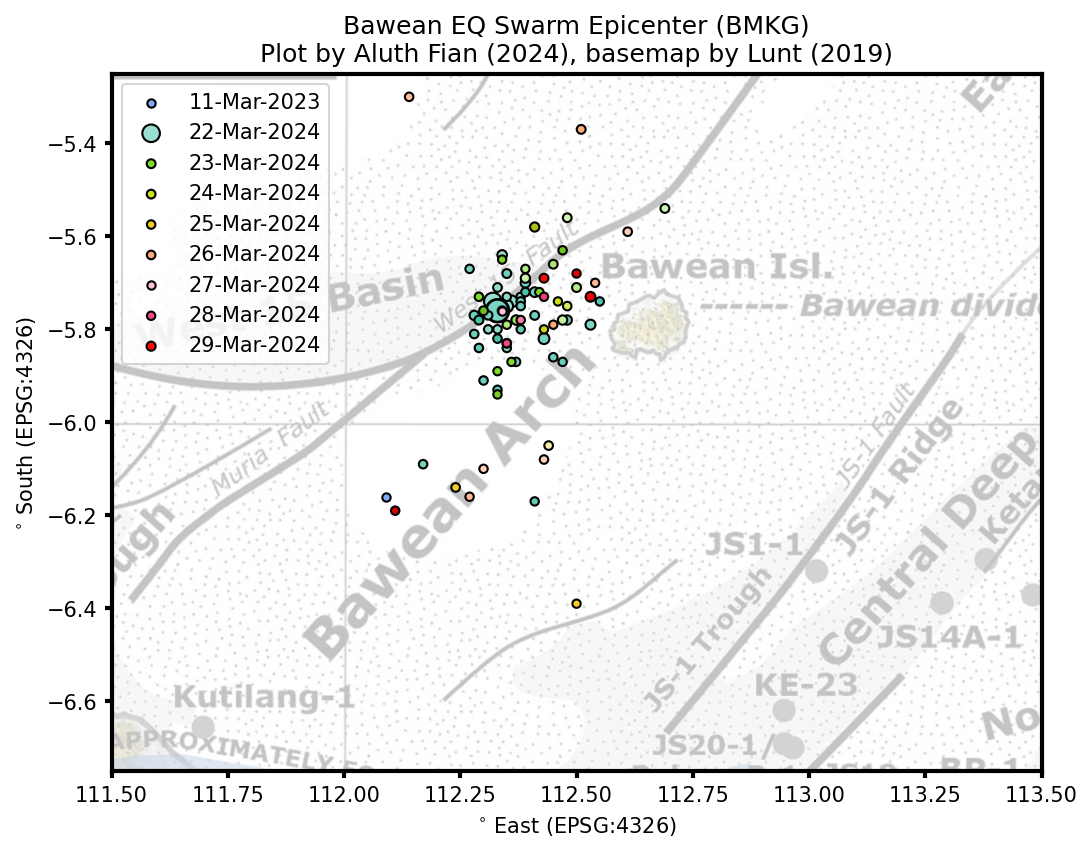

In [6]:
# Plot the RGB image using matplotlib
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
ax.imshow(rgb_image, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top], alpha=0.25)

index = 0
for day in df['Date'].unique():
    df_filtered = df.loc[df['Date']==day].copy()
    color = [lighten_color(palette[index], amount=val) for val in df_filtered['brightness_plot']]
    ax.scatter(df_filtered['Longitude'], df_filtered['Latitude'],
               15+np.power(4,(df_filtered['Magnitude']-df_filtered['Magnitude'].min())),
               color = color, edgecolor='xkcd:black', label=day)
    index +=1
    
ax.set_xlim(111.5, 113.5)
ax.set_ylim(-6.75, -5.25)
ax.legend(loc='upper left')
ax.set_title('Bawean EQ Swarm Epicenter (BMKG)\nPlot by Aluth Fian (2024), basemap by Lunt (2019)')
ax.set_xlabel('$^{\circ}$ East (EPSG:4326)')
ax.set_ylabel('$^{\circ}$ South (EPSG:4326)')

# change each spine separately:
# ax.spines['right'].set_linewidth(0.5)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# increase tick width
ax.tick_params(width=2)

plt.show()